## Project Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pathlib
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random
import seaborn as sns
from collections import Counter

from torch.nn.functional import softmax
from sklearn import metrics




# !cp -r '/content/drive/MyDrive/Colab Notebooks/SatDetectionProject/RBG/' '/content/'


## Downloading The Dataset
The following block of code should be run once to download the datasets, create directories for them, and extract all the contents into the respective directories. The website *zenodo* has an API that allows us to receive information in response to an HTTP request. These TIFF files are held in zip files and must be extracted to work with them directly.
There are two datasets: an RGB basic coloring dataset, and a 13-band coloring dataset. If you wish to work with the multi-band dataset, simply uncomment the related lines of code

In [1]:
# Grab the data from the website zenoto.org using an HTTP request
import requests
import os
from io import BytesIO
from zipfile import ZipFile
!rm -r EuroSAT_RGB
!rm -r RGB

# the dataset includes the images as standard 3-band RGB (red, green, blue) images
rgb_data_url = "https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip"

response_rgb = requests.get(rgb_data_url)
# response_multiband = requests.get(multiband_data_url)

# Raise any exceptions if the http requests rendered any errors
#response_rbg.raise_for_status()


# Extract the zip files
# os.makedirs('Multi', exist_ok=False)
os.makedirs('RGB', exist_ok=False)
'''with ZipFile(BytesIO(response_multiband.content)) as zip_file:
  zip_file.extractall(f"{path}RBG")'''

with ZipFile(BytesIO(response_rgb.content)) as zip_file:
  zip_file.extractall(f"RGB")






rm: cannot remove 'EuroSAT_RGB': No such file or directory
rm: cannot remove 'RGB': No such file or directory


#### DatasetLoader class
This class' objective is to provide a set of instructions for how a dataloader, like that of PyTorch, can interact and load the files from our datasets. We define an initializer (constructor) with image paths in our directory, labels, any transformations we decide for the images. We also define a get item function, which the dataloader can use to efficiently extract individual files from the directories. The len function simply gives us the size of our dataset and the load image function uses the python library *PIL* to load the images. PIL is used instead of *Rasterio* in this case since we know we are working with basic 3-band images.



In [3]:

class EuroSATDataset(Dataset):
  def __init__(self, image_paths, labels, transform=None):
    self.image_paths = image_paths
    self.label_dict = {"AnnualCrop": 0, "Forest":1, "HerbaceousVegetation": 2,
               "Highway": 3, "Industrial": 4, "Pasture": 5, "PermanentCrop": 6,
               "Residential": 7, "River": 8, "SeaLake": 9}
    self.labels = [self.label_dict[label] for label in labels]
    self.transform = transform


# load the tiff file using raster, which accepts multi band files
  def _load_image(self, idx):
    image = Image.open(self.image_paths[idx]).convert('RGB')
    if self.transform:
        image = self.transform(image)
    return image

# returns the number of tiff files in the dataset
  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
      image = self._load_image(idx)
      label = self.labels[idx]
      return image, label




In [4]:
def prepare_data(root_dir):
  image_paths = []
  labels = []
  for _, class_name in enumerate(sorted(os.listdir(root_dir))):
      class_dir = os.path.join(root_dir, class_name)
      for file_name in os.listdir(class_dir):
        if file_name.endswith(".jpg") or file_name.endswith('.tif'):
            image_paths.append(os.path.join(class_dir, file_name))
            labels.append(class_name)
  return image_paths, labels

#### Exploring the data: RBG
Here we will explore the dataset. This block of code will be run in the main block below and will result in visuals of the original images alongside their normalized counterparts


In [5]:
def visualize_data(dataset):
    # let's explore a few images from our dataset to understand what these images look like
    num_samples = 5
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    mean= [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]


    grid = gridspec.GridSpec(num_samples,2)

    for i, idx in enumerate(indices):
      plt.figure(figsize=(10, num_samples*4))
      image, label = dataset[idx]
      original_image = image
      original_image = denormalize_img(original_image, mean, std)
      image = image.permute(1, 2, 0)
      original_image = original_image.permute(1,2,0)

      axis_1 = plt.subplot(grid[i,0])
      axis_1.imshow(original_image)
      axis_1.set_title(label)
      axis_1.axis('off')

      axis_2 = plt.subplot(grid[i,1])
      axis_2.imshow(image)
      axis_2.set_title(label)
      axis_2.axis('off')

      plt.show()






In [6]:
def denormalize_img(image, mean, std):
  # we need to clone the tensor so that python doesn't update the original tensor and the temorary
  # tensor we passed through.
  image = image.clone()
  for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m).clamp_
  return image

## Model Architecture
Our model will take advantage of the CNN (Convolutional Neural Network) architecture to help analyze the images and classify them. We will define the layers of the model, initialize the weights, then define the forward pass.

In [7]:
from math import sqrt

class ConvNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 2, stride = 2)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5, padding = 2, stride = 2)
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 8, kernel_size = 5, padding = 2, stride = 2)
    self.fc_1 = nn.Linear(32, 128)
    self.fc_2 = nn.Linear(128, num_classes)
    self.dropout_fc = nn.Dropout(p=0.5)
    self.batch_norm_1 = nn.BatchNorm2d(16)
    self.batch_norm_2 = nn.BatchNorm2d(64)
    self.batch_norm_3 = nn.BatchNorm2d(8)
    # self.batch_norm_fc = nn.BatchNorm1d(128)


    self.init_weights()

  def init_weights(self):
    torch.manual_seed(42)

    for conv in [self.conv1, self.conv2, self.conv3]:
        C_in = conv.weight.size(1)
        nn.init.normal_(conv.weight, 0.0, 1 / sqrt(5 * 5 * C_in))
        nn.init.constant_(conv.bias, 0.0)

    D_in = self.fc_1.weight.size(1)
    nn.init.normal_(self.fc_1.weight, 0.0, 1 / sqrt(D_in))
    nn.init.constant_(self.fc_1.bias, 0.0)

    D_in = self.fc_2.weight.size(1)
    nn.init.normal_(self.fc_2.weight, 0.0, 1 / sqrt(D_in))
    nn.init.constant_(self.fc_2.bias, 0.0)

  def forward(self, x):
        N, C, H, W = x.shape

        x = F.relu(self.batch_norm_1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.batch_norm_2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.batch_norm_3(self.conv3(x)))
        x = x.view(N, -1)
        x = self.dropout_fc(F.relu(self.fc_1(x)))
        x = self.dropout_fc(self.fc_2(x))
        return x



## Training And Evaluation Helper Functions
We define a train epoch function, an evaluate epoch function, and a save model function.
We then run a loop in main that, while the loss is still steadily decreasing within our patience level, we train and evaluate another epoch. Once we reach our patience level, we break and plot the train and val loss.

In [8]:
def save_checkpoint(model, epoch, stats, file):
    state = {
      'epoch': epoch,
      'state_dict': model.state_dict(),
      'stats': stats
    }

    filename = pathlib.Path(file)
    torch.save(state, filename)


In [9]:
def early_stopping(stats, curr_patience, prev_valid_loss):
    if stats[-1][1] > prev_valid_loss:
        curr_patience += 1
    else:
        curr_patience = 0
        prev_valid_loss = stats[-1][1]
    return curr_patience, prev_valid_loss

In [10]:
def train_epoch(data_loader, model, criterion, optimizer):
    model.cuda()
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X, y = X.cuda(), y.cuda()
        # Clear the gradients
        optimizer.zero_grad()
        # Load up the model with the training data loader
        output = model(X)
        # Calculate the loss using cross entropy loss func
        loss = criterion(output, y)
        # Backpropagate
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print(f"Training batch loss {loss}")

In [11]:
def predictions(logits):
    """Determine predicted class index given logits.

    Returns:
        the predicted class output as a PyTorch Tensor
    """
    # TODO implement predictions

    pred = torch.argmax(logits, dim = 1)
    return pred

## Evaluation functions
These nested functions help break down the entire validation and test evaluation. Get metrics will produce the necessary metrics to collect our statistics. Eval Epoch makes use of thi information to fill our stats list, and will produce confusion matrix and classification report if the test loader is passed in

In [29]:
def eval_epoch(
    train_load,
    valid_load,
    model,
    criterion,
    epoch,
    stats,
    test_load = None,
    update_plot=True):

    def get_metrics(load):
        model.eval()
        y_true, y_pred, y_score = [], [], []
        correct, total = 0, 0
        running_loss = []
        for i, (X, y) in enumerate(load):
            with torch.no_grad():
          # our project leverages the GPU offered by colab so we're going to
          # set the data to work with cuda
                X, y = X.cuda(), y.cuda()
                output = model(X)
                predicted = predictions(output.data)
                y_true.append(y)
                y_pred.append(predicted)
                y_score.append(softmax(output.data, dim = 1))
                total += len(y)
                correct += (predicted == y).sum().item()
                running_loss.append(criterion(output, y).item())
        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)
        y_score = torch.cat(y_score)
        loss = np.mean(running_loss)
        accuracy = correct / total
        return accuracy, loss, y_true, y_score

    train_accuracy, train_loss, _, _ = get_metrics(train_load)
    print(f"epoch {epoch}, {train_accuracy}, {train_loss}")
    valid_accuracy, valid_loss,_, _ = get_metrics(valid_load)
    print(f"epoch {epoch}, {valid_accuracy}, {valid_loss}")
    epoch_stats = [
        valid_accuracy,
        valid_loss,
        train_accuracy,
        train_loss,
    ]

    if test_load:
        epoch_stats += get_metrics(test_load)
        y_true, y_score = epoch_stats[-2], epoch_stats[-1]
        y_pred = torch.argmax(y_score, dim = 1)

        conf_mat = metrics.confusion_matrix(y_true.cpu().numpy(), y_pred.cpu().numpy())
        plt.figure(figsize=(10,8))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        class_report = metrics.classification_report(y_true.cpu().numpy(), y_pred.cpu())
        print(class_report)

    stats.append(epoch_stats)

    # add some type of update plot



## Project Driver: Initializes model, downloads and prepares data, then trains and evaluates the model.


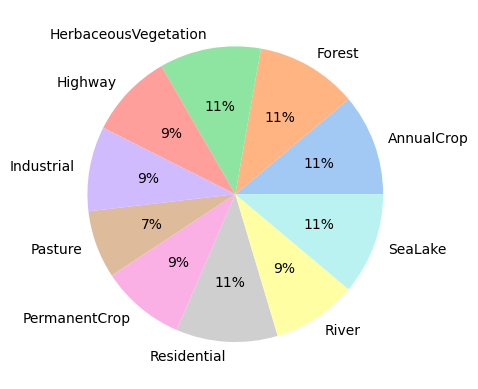

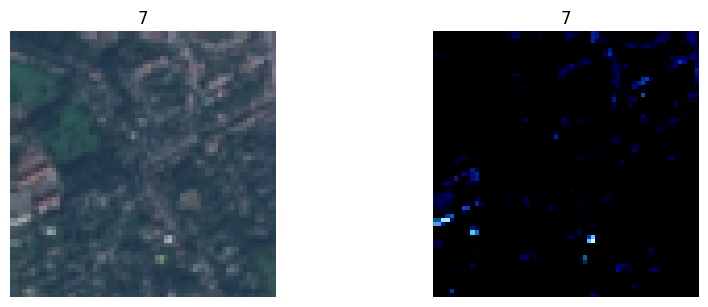

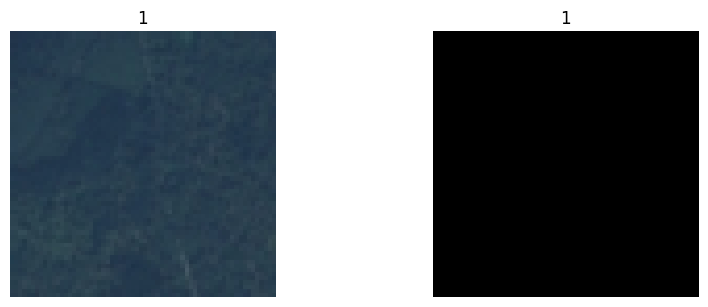

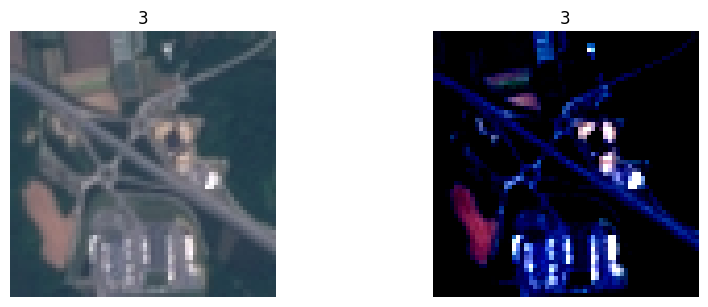

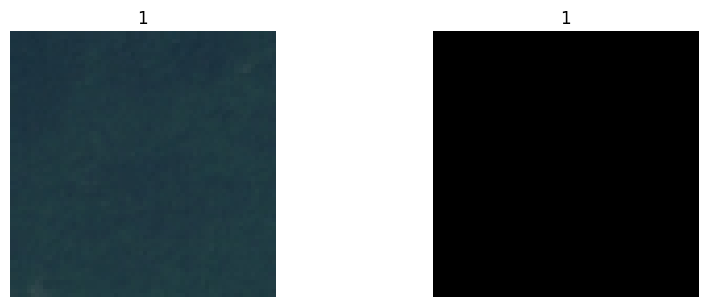

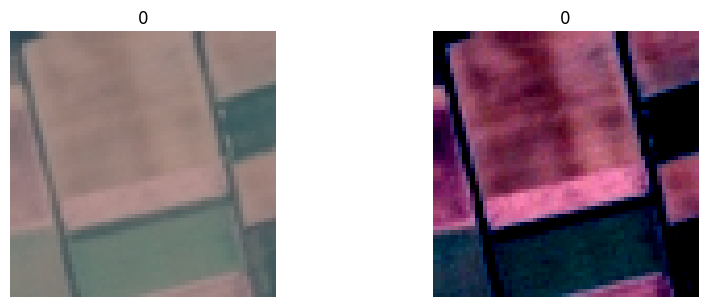

epoch 0, 0.06689814814814815, 2.3497928803055377
epoch 0, 0.06407407407407407, 2.3485486170824834
[0.06407407407407407, 2.3485486170824834, 0.06689814814814815, 2.3497928803055377]
Training batch loss 2.561795711517334
epoch 0, 0.6424537037037037, 1.1587868701087103
epoch 0, 0.6296296296296297, 1.1662252166691949
Training batch loss 1.6178429126739502
epoch 1, 0.7414351851851851, 1.0020241415942157
epoch 1, 0.7425925925925926, 1.0077077732366675
Training batch loss 1.4078456163406372
epoch 2, 0.7343055555555555, 0.9069036037833602
epoch 2, 0.7255555555555555, 0.9205524051890653
Training batch loss 1.2818952798843384
epoch 3, 0.7643518518518518, 0.9262410524156358
epoch 3, 0.7514814814814815, 0.9447615441154031
Training batch loss 1.4405542612075806
epoch 4, 0.770787037037037, 0.8282891136628611
epoch 4, 0.7511111111111111, 0.8580992495312411
Training batch loss 1.377699613571167
epoch 5, 0.7557407407407407, 0.9040710492045791
epoch 5, 0.7477777777777778, 0.9167482733726502
Training bat

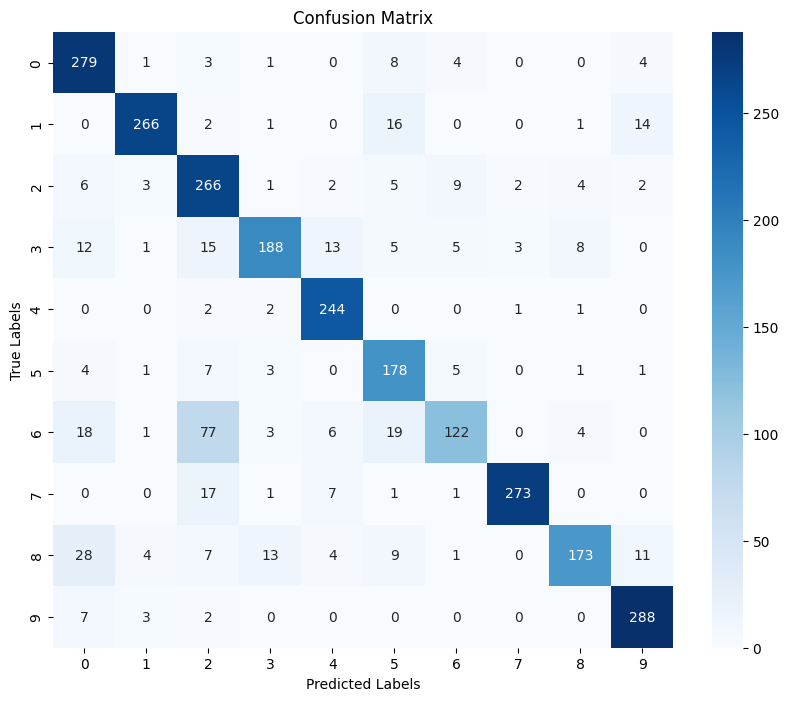

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       300
           1       0.95      0.89      0.92       300
           2       0.67      0.89      0.76       300
           3       0.88      0.75      0.81       250
           4       0.88      0.98      0.93       250
           5       0.74      0.89      0.81       200
           6       0.83      0.49      0.61       250
           7       0.98      0.91      0.94       300
           8       0.90      0.69      0.78       250
           9       0.90      0.96      0.93       300

    accuracy                           0.84      2700
   macro avg       0.85      0.84      0.83      2700
weighted avg       0.85      0.84      0.84      2700



IndexError: ignored

In [23]:

# make an instance of the model, set the loss func and optimizer
model = ConvNet()
model.cuda()
#model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001, weight_decay = .01)

# initialize some useful variables for evaluating our model
stats = []
start_epoch = 0
patience = 5
current_patience = 0

# create a transformations object for our dataset to inherit
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load in the dataset
image_paths, labels = prepare_data(root_dir=pathlib.Path(f"/content/RGB/EuroSAT_RGB"))

class_count = Counter(labels)
class_names = list(class_count.keys())
counts = list(class_count.values())


plt.pie(counts, labels=class_names, colors=sns.color_palette('pastel'),
        autopct='%.0f%%')

plt.show()

# --- split the data between train, valid, and test ---
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels,
                                                    test_size=0.2, random_state=84, stratify = labels)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5, random_state=84, stratify = y_test)


train_dataset = EuroSATDataset(image_paths=X_train, labels=y_train, transform=transform)
valid_dataset = EuroSATDataset(image_paths=X_valid, labels=y_valid, transform=transform)
test_dataset = EuroSATDataset(image_paths=X_test, labels=y_test, transform=transform)

visualize_data(train_dataset)
test_load = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers=os.cpu_count())
train_load = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=os.cpu_count())
valid_load = DataLoader(valid_dataset, batch_size = 32, shuffle = False, num_workers=os.cpu_count())

# To have a baseline validation loss to compare, we evaluate an epoch
# of the model with random initialization

eval_epoch(train_load, valid_load, model, criterion, start_epoch, stats
)

prev_valid_loss = stats[-1][1]
print(stats[-1])

while current_patience < patience:
  # train model for an epoch
    train_epoch(train_load, model, criterion, optimizer)
    eval_epoch(train_load, valid_load, model, criterion, start_epoch, stats)
    if prev_valid_loss > stats[-1][1]:
        save_checkpoint(model, start_epoch, stats, 'best_model.pt')
    current_patience, prev_valid_loss = early_stopping(stats, current_patience, prev_valid_loss)
    start_epoch +=1

# test the model against the test set
model.load_state_dict(torch.load('best_model.pt')["state_dict"])
eval_epoch(train_load, valid_load, model, criterion, start_epoch, stats, test_load)

test_accuracy, test_loss = stats[-1][-4:-2]
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")
# plots_n_graphs(model, stats, start_epoch)




## Plots of Validation and Trianing Performance
Below is a section that can be run once the training and validation has been completed in the code block above. It will load the last saved model (the last epoch of validation with a loss less than the previous) and grab the necessary statistics. It then will produce loss and accuracy plots for both the validation and training sets.

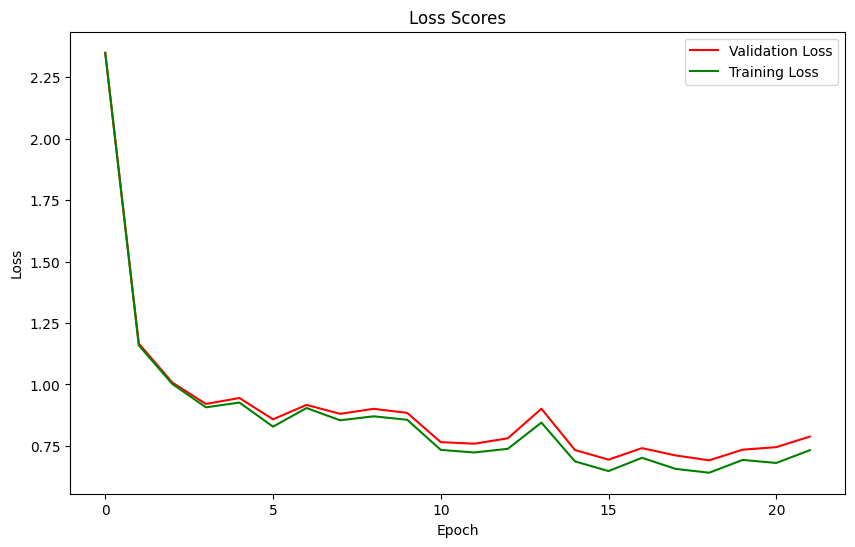

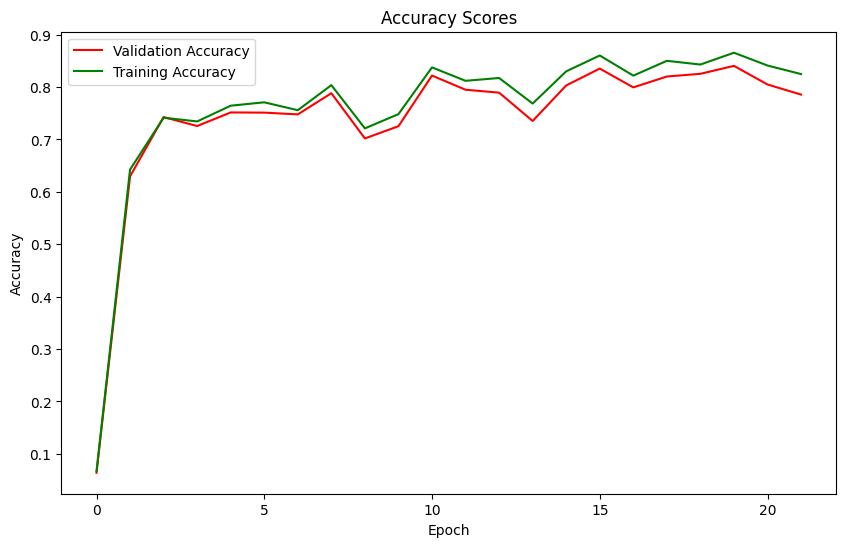

In [41]:
best_model = torch.load('best_model.pt')
epochs = list(range(best_model["epoch"]))
stats = best_model["stats"]
valid_accuracy = [epoch[0] for epoch in stats[:]]
valid_loss = [epoch[1] for epoch in stats[:]]
train_accuracy = [epoch[2] for epoch in stats[:]]
train_loss = [epoch[3] for epoch in stats[:]]

# auroc curve

plt.figure(figsize=(10,6))
plt.plot(epochs, valid_loss, 'r', label = "Validation Loss")
plt.plot(epochs, train_loss, 'g', label = "Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Scores")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(epochs, valid_accuracy, 'r', label = "Validation Accuracy")
plt.plot(epochs, train_accuracy, 'g', label = "Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores")
plt.legend()
plt.show()
